**Name:** Derek Stiles 
<br>
**Project:** Module 2 - Northwind Database 

<img src='Northwind_ERD.png'>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

# 1: Do discounts have a statistically significant impact on the number of products that customers order? If so, at what levels? 

## 1.1: Exploratory Data Analysis

In [3]:
c.execute('''SELECT *
            FROM OrderDetail
            ORDER BY Discount DESC;''')

orders = pd.DataFrame(c.fetchall())
orders.columns = [i[0] for i in c.description]

In [4]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [6]:
orders['OrderId'] = orders['OrderId'].astype(object)

Let's take a look at what discount values were offered on the orders.

In [7]:
orders['Discount'].unique()

array([0.25, 0.2 , 0.15, 0.1 , 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.  ])

We have a range of 0 (no discount) to 25% off. Together, we have 11 different discounts if we include 0. 

In [8]:
orders['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.06       1
0.04       1
Name: Discount, dtype: int64

Since a handful of the discounts (1%, 2%, 3%, 4%, 6%) were only used on rare occasions, it will make for easier analysis to treat these as 5% discounts. 

In [9]:
orders['Discount'] = np.where(orders['Discount'].between(.01,.06), 0.05, orders['Discount'])
orders['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Now that we have the discounts cleaned into 6 distinct levels, we can perform some exploratory analysis prior to forming our hypotheses. 

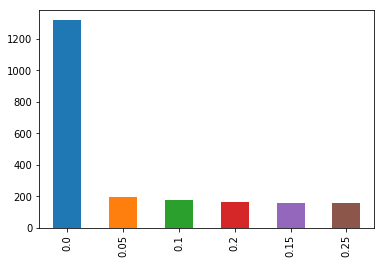

In [10]:
fig, ax = plt.subplots()
orders['Discount'].value_counts().plot(ax=ax, kind='bar')

As we can see, most orders don't have any discounts attached to them. Otherwise, when a discount is applied, each of our discount levels are used at the same rate. 

In [11]:
orders.describe()

,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000
mean,40.793039,26.218520,23.812993,0.056241
std,22.159019,29.827418,19.022047,0.083431
min,1.000000,2.000000,1.000000,0.000000
25%,22.000000,12.000000,10.000000,0.000000
50%,41.000000,18.400000,20.000000,0.000000
75%,60.000000,32.000000,30.000000,0.100000
max,77.000000,263.500000,130.000000,0.250000


The average **quantity** of an order is 23.8 items, while the median is 20, which tells us that the distribution is positively skewed. In addition, the average **discount** provided on an order is just about 5%, which is what we'd expect after visualizing discount frequency above.

/Users/Derek/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Quantity Ordered')

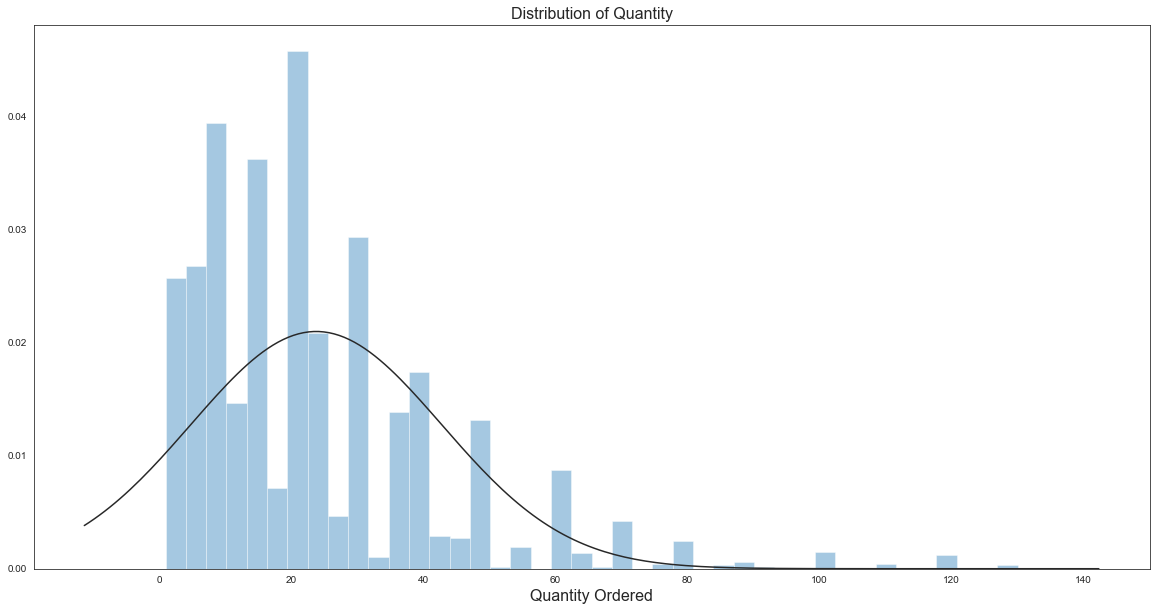

In [12]:
from scipy.stats import norm

sns.set_style('white')

plt.figure(figsize=(20, 10))
sns.distplot(orders['Quantity'], fit=norm, kde=False)
plt.title('Distribution of Quantity', fontsize=16)
plt.xlabel('Quantity Ordered', fontsize=16)

Our distribution chart reaffirms our previous belief: the quantity distribution is heavily skewed. Although the data doesn't fit a normal distribution, we can rely on our knowledge of the central limit theorem, which states that the averages of samples will form a normal distribution. 

**(Use SciPy's normaltest when taking samples to provide quantitative measure of normality)** 

Before jumping into any hypothesis testing, let's visualize the range of quantity per each discount via box plots.

In [13]:
boxplot_purposes = orders.copy()
boxplot_purposes['Discount'] = boxplot_purposes['Discount'].astype(object)

Text(0.5,0,'Quantity Ordered')

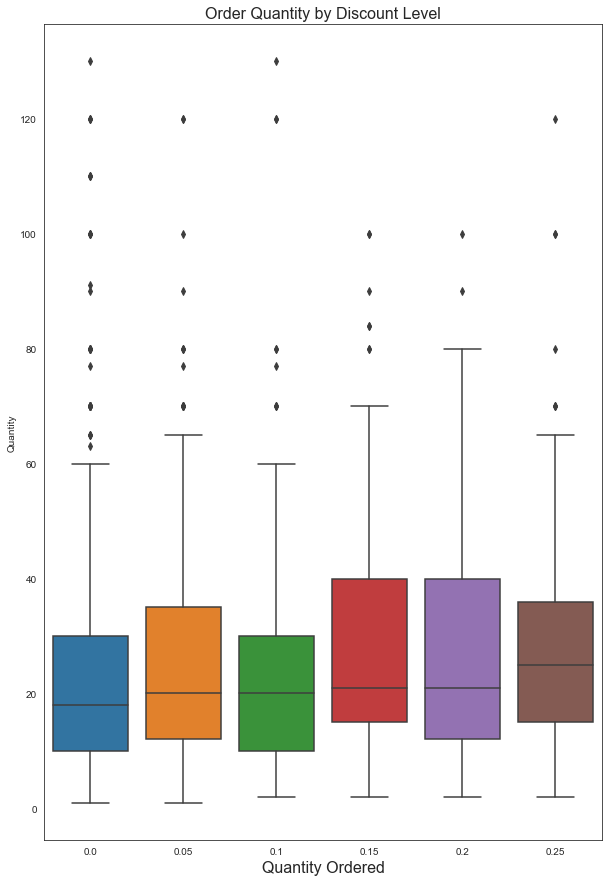

In [14]:
plt.figure(figsize=(10, 15))
sns.boxplot(x='Discount', y='Quantity', data=boxplot_purposes)
plt.title('Order Quantity by Discount Level', fontsize=16)
plt.xlabel('Quantity Ordered', fontsize=16)

In [15]:
orders.groupby('Discount', as_index=False)['Quantity'].mean()

,Discount,Quantity
0,0.00,21.715262
1,0.05,26.922280
2,0.10,25.236994
3,0.15,28.382166
4,0.20,27.024845
5,0.25,28.240260


A visual inspection of the boxplot shows that there is an increase in order quantity when discounts are applied. In addition, the chart above shows that order quantity increase from approximately 22 to approximately 25 when at least a 5% discount is put into place. **Based on this information, we can say it's worth inspecting as to whether or not there is a statistically significant difference between quantities of discounted orders and quantities of non-discounted orders.**

However, we'll need to perform some hypothesis testing to provide quanitative information to back up this finding and understand discount level affects quantity the most.

## 1.2: Hypotheses

We are looking to test whether or not discounts affect customer behavior - **do discounts increase order sizes? If so, at what levels?**

To answer the question of whether or not discounts play a statistically significant role in increasing order quantity, we'll set up a null and alternative hypothesis. 

The *null hypothesis (denoted as $H_O$)* basically says there is no relationship between A and B. This is the hypothesis we are aiming to reject. The *alternative hypothesis (denoted as $H_A$)*, on the other hand, says there is some sort of relationship between A and B. 

**$H_O$: The average quantity ordered by customers who do receive a discount is no different from that of customers who do not receive a discount.**

**$H_A$: The average quantity ordered by customers who receive a discount is greater than 21.72 (the average quantity ordered by customers who did not receive a discount).**

In order to reject (or fail to reject) our null hypothesis, we'll perform a two-sample t-test

A two-sample t-test is a statistical test that is used to determine whether the difference between two groups is statistically significant or simply due to chance. To perform this, we'll need a control group and an experimental group. **The control group will be all customers orders that did NOT receive a discount and the experimental group will be all customer orders that DID receive a discount.** This will allow us to answer the first question that Northwind is trying to figure out: do discounts increase order quantities? 

In [16]:
control = orders[orders['Discount'] ==0]
control = control['Quantity']
exp = orders[orders['Discount'] != 0]
exp = exp['Quantity']

## 1.3: T-Test Assumptions

When performing a t-test, data must meet certain assumptions, otherwise the t-test may lead to misleading results. I will outline the three basic assumptions below and how the data will meet each of them. 

- Normal

- Independent

- Random


In [17]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
       x = np.random.choice(data)
       sample.append(x)
    
    return sample

In [18]:
def get_sample_mean(sample):
    return sum(sample) / len(sample)

In [19]:
def create_sample_distribution(data, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [20]:
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(exp)

/Users/Derek/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Quantity of Product Ordered')

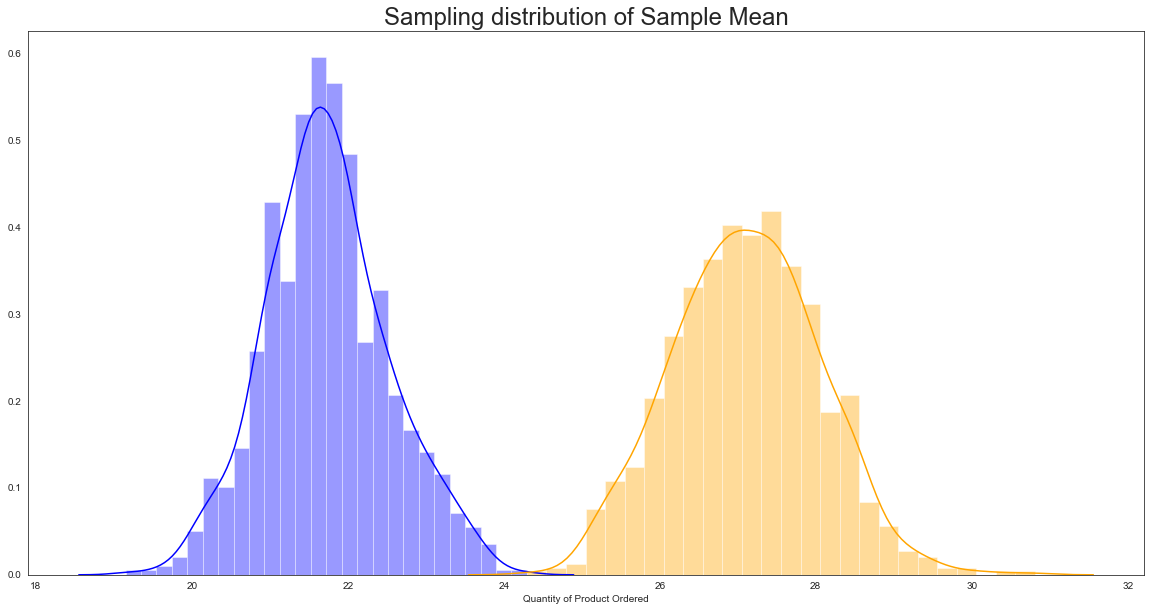

In [21]:
plt.figure(figsize=(20,10))
sns.distplot(control_sample, color='blue')
sns.distplot(exp_sample, color='orange')
sns.set(font_scale=2)
plt.title('Sampling distribution of Sample Mean')
plt.xlabel('Quantity of Product Ordered')

In [22]:
control_sample = np.array(control_sample)
exp_sample = np.array(exp_sample)

## 1.5: Two Sample T-Test

In [23]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
        
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return numerator/denominator

welch_t(exp_sample,control_sample)

138.26860094707473

In [24]:
stats.ttest_ind(exp_sample, control_sample, axis=0, equal_var=False)

Ttest_indResult(statistic=138.26860094707473, pvalue=0.0)

In [25]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [26]:
Cohen_d(exp_sample, control_sample)

6.1866539181067175

## 1.6: ANOVA Testing

In [27]:
orders['Quantity'].groupby(orders['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.05,193.0,26.922280,22.345981,1.0,12.0,20.0,35.0,120.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0
0.25,154.0,28.240260,20.120570,2.0,15.0,25.0,36.0,120.0


In [28]:
formula = 'Quantity ~ Discount'
lm = ols(formula, orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df          F        PR(>F)
Discount   12685.217865     1.0  35.621182  2.795255e-09
Residual  766714.418330  2153.0        NaN           NaN


In [29]:
results = ols('Quantity ~ C(Discount)', data=orders).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.990
Date:                Thu, 30 May 2019   Prob (F-statistic):           1.82e-08
Time:                        17:06:03   Log-Likelihood:                -9382.8
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2149   BIC:                         1.881e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              21.7153      0.519     41.811      0.000      20.697      22.734
C(Discount)[T.0.05]     5.2070      1.453      3.584      0.000       2.358       8.056
C(Discount)[T.0.1]      3.5217      1.524      2.311      0.021       0.533       6.511
C(Discount)[T.0.15]     6.6669      1.591      4.189      0.000       3.546       9.788
C(Discount)[T.0.2]      5.3096      1.574      3.374      0.001       2.224       8.396
C(Discount)[T.0.25]     6.5250      1.605      4.065      0.000       3.377       9.673
==============================================================================
Omnibus:                      785.939   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3068.948
Skew:                           1.766   Prob(JB):                         0.00
Kurtosis:                       7.658   Cond. No.                         4.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(orders.Quantity, orders.Discount)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   5.207    1.0635  9.3506  True 
 0.0    0.1    3.5217  -0.8257  7.8692 False 
 0.0    0.15   6.6669   2.1279 11.2059  True 
 0.0    0.2    5.3096   0.8212  9.7979  True 
 0.0    0.25   6.525    1.9467 11.1033  True 
 0.05   0.1   -1.6853  -7.3138  3.9432 False 
 0.05   0.15   1.4599  -4.3179  7.2377 False 
 0.05   0.2    0.1026  -5.6355  5.8406 False 
 0.05   0.25   1.318   -4.4907  7.1267 False 
 0.1    0.15   3.1452  -2.7805  9.0709 False 
 0.1    0.2    1.7879  -4.0991  7.6748 False 
 0.1    0.25   3.0033  -2.9526  8.9591 False 
 0.15   0.2   -1.3573  -7.3872  4.6725 False 
 0.15   0.25  -0.1419   -6.239  5.9552 False 
 0.2    0.25   1.2154  -4.8441  7.2749 False 
---------------------------------------------


In [31]:
stats.shapiro(results.resid)

(0.8617812991142273, 5.71193076132689e-40)

In [32]:
stats.levene(orders['Quantity'][orders['Discount'] == 0.05],
             orders['Quantity'][orders['Discount'] == 0.10],
             orders['Quantity'][orders['Discount'] == 0.15],
             orders['Quantity'][orders['Discount'] == 0.20],
             orders['Quantity'][orders['Discount'] == 0.25])

LeveneResult(statistic=0.23741425853156475, pvalue=0.9172428335770793)

## 1.7: Bonferroni Correction Post-Hoc Comparison

The correct p-values must be calculated:

p-value/number of comparisons = corrected p-value

In [33]:
p_value = .05
no_of_comparisons = 6
p_value/no_of_comparisons

0.008333333333333333

**(Want to figure out how to clean this up using a function)**

In [34]:
stats.ttest_ind(orders['Quantity'][orders['Discount'] == 0.0], orders['Quantity'][orders['Discount'] == 0.05])

Ttest_indResult(statistic=-3.712926500155175, pvalue=0.00021233599028873263)

In [35]:
stats.ttest_ind(orders['Quantity'][orders['Discount'] == 0.0], orders['Quantity'][orders['Discount'] == 0.15])

Ttest_indResult(statistic=-4.411192556207304, pvalue=1.1027809944864872e-05)

In [36]:
stats.ttest_ind(orders['Quantity'][orders['Discount'] == 0.0], orders['Quantity'][orders['Discount'] == 0.20])

Ttest_indResult(statistic=-3.6019486047561884, pvalue=0.00032631258591041463)

In [37]:
stats.ttest_ind(orders['Quantity'][orders['Discount'] == 0.0], orders['Quantity'][orders['Discount'] == 0.25])

Ttest_indResult(statistic=-4.304937285665697, pvalue=1.780928988051903e-05)

## 1.8: Conclusions

- Based on our statistical testing, we can confidently reject the null hypothesis that says there is no difference in non-discounted order quantities and discounted order quantities. 

- Analyzing the discounts at specific levels, we came away with the finding that there is a statistically significant increase in order quantity between non-discounted orders and discounted orders of 5%, 15%, 20%, and 25%. 

# 2: Does time of year have a statistically significant impact on freight costs?

**$H_O$: There is no difference in average freight price for each month.**

**$H_A$: There is at least one average freight price that is different amongst all months.**

## 2.1: Exploratory Data Analysis & Cleaning

In [38]:
c.execute('''SELECT *
             FROM 'Order';''')
freight = pd.DataFrame(c.fetchall())
freight.columns = [i[0] for i in c.description]
freight.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [39]:
freight = freight.drop(['CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShipName', 
                        'ShipCity', 'ShipAddress', 'ShipRegion', 'ShipPostalCode', 'ShipCountry'], axis=1)

In [40]:
freight.head()

,Id,ShippedDate,ShipVia,Freight
0,10248,2012-07-16,3,32.38
1,10249,2012-07-10,1,11.61
2,10250,2012-07-12,2,65.83
3,10251,2012-07-15,1,41.34
4,10252,2012-07-11,2,51.30


In [41]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
Id             830 non-null int64
ShippedDate    809 non-null object
ShipVia        830 non-null int64
Freight        830 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 26.0+ KB


In [42]:
freight['ShippedDate'].isnull().sum()

21

In [43]:
freight['ShipVia'] = freight['ShipVia'].astype('object')

In [44]:
freight_null = freight[freight.isna().any(axis=1)]

In [45]:
freight_null

,Id,ShippedDate,ShipVia,Freight
760,11008,None,3,79.46
771,11019,None,3,3.17
791,11039,None,2,65.00
792,11040,None,3,18.84
797,11045,None,2,70.58
803,11051,None,3,2.79
806,11054,None,1,0.33
810,11058,None,3,31.14
811,11059,None,2,85.80
813,11061,None,3,14.01


The null values under shipping date give no indication as to what month they might be, so we will delete these from our analysis. 

In [46]:
freight = freight.dropna()

In [47]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 4 columns):
Id             809 non-null int64
ShippedDate    809 non-null object
ShipVia        809 non-null object
Freight        809 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.6+ KB


Now that null values are dropped, we can move on to converting the current date format to just month names, since we're only concerned about the time of year affecting freight prices.

In [48]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 4 columns):
Id             809 non-null int64
ShippedDate    809 non-null object
ShipVia        809 non-null object
Freight        809 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.6+ KB


In [49]:
freight.head()

,Id,ShippedDate,ShipVia,Freight
0,10248,2012-07-16,3,32.38
1,10249,2012-07-10,1,11.61
2,10250,2012-07-12,2,65.83
3,10251,2012-07-15,1,41.34
4,10252,2012-07-11,2,51.30


In [50]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 4 columns):
Id             809 non-null int64
ShippedDate    809 non-null object
ShipVia        809 non-null object
Freight        809 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.6+ KB


In [51]:
freight['ShippedDate'] = pd.to_datetime(freight['ShippedDate'])

In [52]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 4 columns):
Id             809 non-null int64
ShippedDate    809 non-null datetime64[ns]
ShipVia        809 non-null object
Freight        809 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.6+ KB


In [53]:
freight['ShippedDate'] = freight['ShippedDate'].dt.strftime('%m')

In [54]:
freight.head()

,Id,ShippedDate,ShipVia,Freight
0,10248,07,3,32.38
1,10249,07,1,11.61
2,10250,07,2,65.83
3,10251,07,1,41.34
4,10252,07,2,51.30


In [55]:
freight['ShippedDate'] = freight['ShippedDate'].astype(int)

In [57]:
import calendar

In [58]:
freight['ShippedDate'] = freight['ShippedDate'].apply(lambda x: calendar.month_name[x])

In [59]:
freight.head()

,Id,ShippedDate,ShipVia,Freight
0,10248,July,3,32.38
1,10249,July,1,11.61
2,10250,July,2,65.83
3,10251,July,1,41.34
4,10252,July,2,51.30


We converted the shipped dates to month names. Now let's do some exploratory analysis before heading into any statistical testing.

In [60]:
freight.groupby('ShippedDate', as_index=False)['Freight'].mean()

,ShippedDate,Freight
0,April,92.036250
1,August,84.486271
2,December,84.412609
3,February,84.929012
4,January,73.901000
5,July,55.250000
6,June,107.798667
7,March,64.728485
8,May,84.648958
9,November,67.645357


/Users/Derek/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


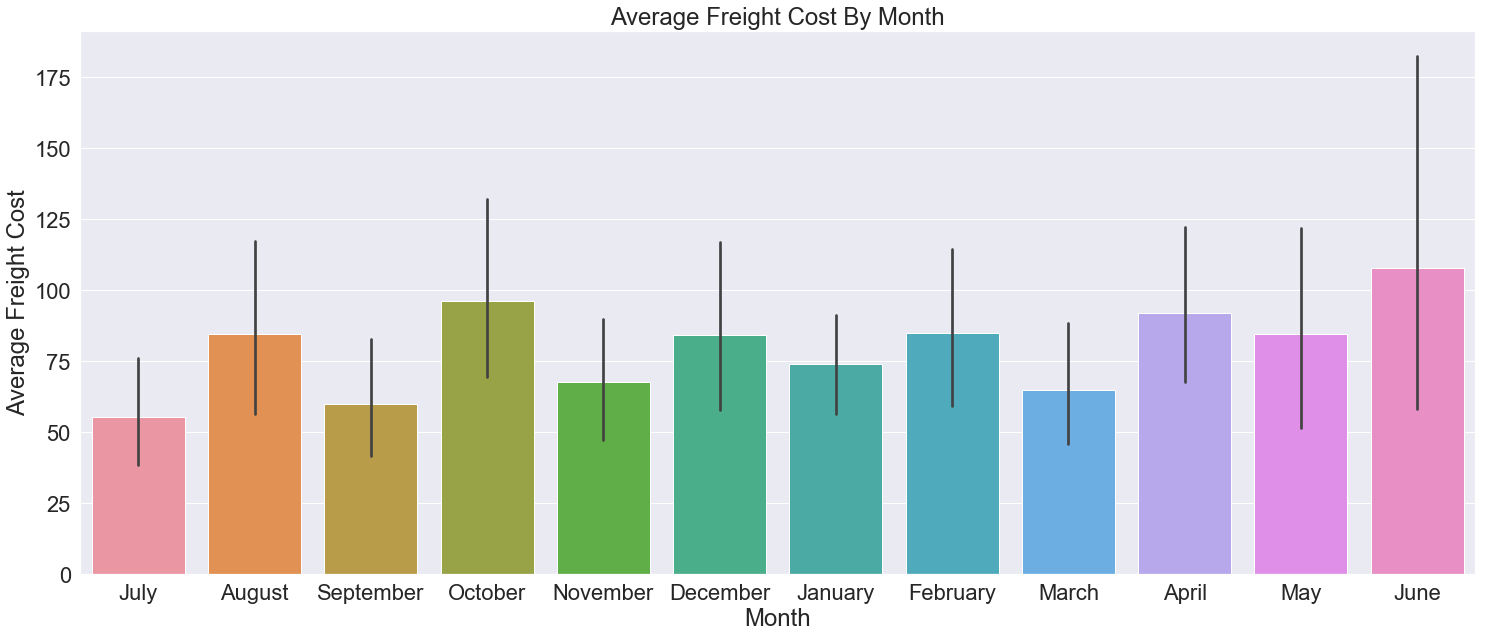

In [61]:
plt.figure(figsize=(25,10))
sns.barplot('ShippedDate', 'Freight', data=freight)
sns.set_context(font_scale=.02)
plt.title('Average Freight Cost By Month')
plt.xlabel('Month')
plt.ylabel('Average Freight Cost')
plt.show()

In [62]:
freight['ShippedDate'].value_counts()

April        104
March         99
January       90
February      81
December      69
October       66
August        59
September     59
November      56
July          48
May           48
June          30
Name: ShippedDate, dtype: int64

In [63]:
freight['ShipVia'].value_counts()

2    315
3    249
1    245
Name: ShipVia, dtype: int64

We can immediately see that freight costs in October and June are higher than the rest of the months while July, September, and March are the lowest. 

However, there is at least one major outlier within October, April, May, and June that's jacking up their averages. Let's delete those so we have a more accurate depiction of what each month's average freight cost is.

In [64]:
freight.loc[freight['ShippedDate'] == 'June'].head()

,Id,ShippedDate,ShipVia,Freight
288,10536,June,2,58.88
292,10540,June,3,1007.64
297,10545,June,2,11.92
299,10547,June,2,178.43
300,10548,June,2,1.43


Immediately we're able to see that the outlier is ID #10540, which had a freight cost of 1007.64. For the purposes of this analysis, let's remove the outlier.

In [65]:
freight = freight.drop(freight.index[292])

In [66]:
freight.loc[freight['ShippedDate'] == 'April'].head()

,Id,ShippedDate,ShipVia,Freight
227,10475,April,1,68.52
234,10482,April,3,7.48
235,10483,April,2,15.28
236,10484,April,3,6.88
238,10486,April,2,30.53


In [67]:
freight = freight.drop(freight.index[782])

In [68]:
freight.loc[freight['ShippedDate'] == 'October'].head()

,Id,ShippedDate,ShipVia,Freight
54,10302,October,2,6.27
57,10305,October,3,257.62
61,10309,October,1,47.30
64,10312,October,2,40.26
65,10313,October,2,1.96


In [69]:
freight = freight.drop(freight.index[443])

In [70]:
freight.loc[freight['ShippedDate'] == 'May'].head()

,Id,ShippedDate,ShipVia,Freight
258,10506,May,2,21.19
260,10508,May,2,4.99
266,10514,May,2,789.95
267,10515,May,1,204.47
268,10516,May,3,62.78


In [71]:
freight = freight.drop(freight.index[266])

/Users/Derek/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


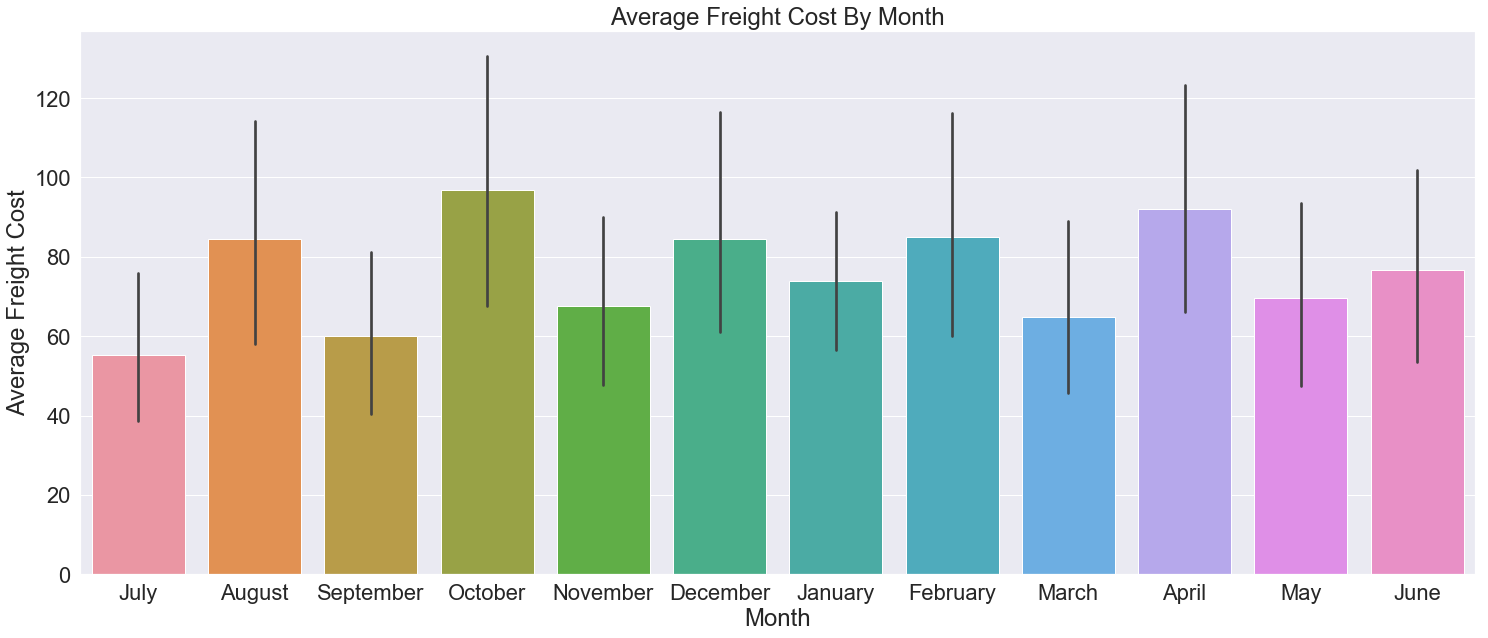

In [72]:
plt.figure(figsize=(25,10))
sns.barplot('ShippedDate', 'Freight', data=freight)
sns.set_context(font_scale=.02)
plt.title('Average Freight Cost By Month')
plt.xlabel('Month')
plt.ylabel('Average Freight Cost')
plt.show()

It's interesting that each season seems to be distinct in terms of how busy it is. Fall months (September-November) are moderately busy, the winter (December-February) is slightly busyier, and the early portion of spring (March and April) are the busiest time of the year. Meanwhile, the summer is the slowest period for shipping.


## 2.3: ANOVA Testing

In [76]:
results = ols('Freight ~ C(ShippedDate)', data=freight).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                      sum_sq     df         F    PR(>F)
C(ShippedDate)  1.242716e+05   11.0  0.922147  0.518166
Residual        9.715211e+06  793.0       NaN       NaN


## 2.4: Conclusion

Our ANOVA testing shows a p-score of approximately .52, which means there is above a 50% chance that any difference in average freight price per month is due to chance. Therefore, we cannot reject our null hypothesis, which states that there is no difference between average monthly freight prices.

# 3: Is there a difference in unit price between supplier regions? 

**$H_O$: There is no difference in average unit price between supplier regions.**

**$H_A$: There is at least one average unit price that is different amongst supplier regions.**

## 3.1: Exploratory Data Analysis/Cleaning

In [77]:
c.execute('''SELECT Region, UnitPrice,Product.ID,ProductName
             FROM Supplier
             JOIN Product
             ON SupplierID;''')

In [78]:
supplier = pd.DataFrame(c.fetchall())
supplier.columns = [i[0] for i in c.description]
supplier.head()

,Region,UnitPrice,Id,ProductName
0,British Isles,18.0,1,Chai
1,North America,18.0,1,Chai
2,North America,18.0,1,Chai
3,Eastern Asia,18.0,1,Chai
4,Southern Europe,18.0,1,Chai


In [79]:
supplier_grouped = supplier.groupby(supplier['ProductName'])

In [80]:
len(supplier['ProductName'].unique())

77

In [81]:
supplier.groupby(['ProductName','Region'])['UnitPrice'].mean()

ProductName                Region         
Alice Mutton               British Isles      39.00
                           Eastern Asia       39.00
                           NSW                39.00
                           North America      39.00
                           Northern Europe    39.00
                           Scandinavia        39.00
                           South America      39.00
                           South-East Asia    39.00
                           Southern Europe    39.00
                           Victoria           39.00
                           Western Europe     39.00
Aniseed Syrup              British Isles      10.00
                           Eastern Asia       10.00
                           NSW                10.00
                           North America      10.00
                           Northern Europe    10.00
                           Scandinavia        10.00
                           South America      10.00
                     

Based off a quick look of our dataframe, it seems that product unit costs are the same across all countries. Perhaps some incredible trade deal was struck where all regions agreed to sell products at the same costs! Just to be sure, let's perform an ANOVA test on it. 

## 3.2: ANOVA Testing

In [ ]:
results = ols('UnitPrice ~ C(Region)', data=supplier).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

## 3.3: Conclusion

As we can see, our p-value is 1, which indicates that it is NOT statistically significant. Therefore, we cannot reject the null hypothesis stating that there is no difference in product unit price between supplier regions.

# 4: Is there a difference in shipping company performance? 

**$H_O$: There is no difference in how quickly shipping companies ship order.**

**$H_A$: Shipping companies ship orders at different speeds.**

## 4.1: Exploratory Data Analysis & Cleaning

In [82]:
c.execute('''SELECT CompanyName, OrderDate, RequiredDate, ShippedDate, ShipRegion, "Order".ID
             FROM Shipper
             JOIN "Order"
             ON Shipper.ID = ShipVia;''')
shipping = pd.DataFrame(c.fetchall())
shipping.columns = [i[0] for i in c.description]
shipping.head()

,CompanyName,OrderDate,RequiredDate,ShippedDate,ShipRegion,Id
0,Federal Shipping,2012-07-04,2012-08-01,2012-07-16,Western Europe,10248
1,Speedy Express,2012-07-05,2012-08-16,2012-07-10,Western Europe,10249
2,United Package,2012-07-08,2012-08-05,2012-07-12,South America,10250
3,Speedy Express,2012-07-08,2012-08-05,2012-07-15,Western Europe,10251
4,United Package,2012-07-09,2012-08-06,2012-07-11,Western Europe,10252


In [83]:
shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
CompanyName     830 non-null object
OrderDate       830 non-null object
RequiredDate    830 non-null object
ShippedDate     809 non-null object
ShipRegion      830 non-null object
Id              830 non-null int64
dtypes: int64(1), object(5)
memory usage: 39.0+ KB


In [99]:
shipping['RequiredDate'] = pd.to_datetime(shipping['RequiredDate'])
shipping['OrderDate'] = pd.to_datetime(shipping['OrderDate'])

In [100]:
shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 7 columns):
CompanyName     830 non-null object
OrderDate       830 non-null datetime64[ns]
RequiredDate    830 non-null datetime64[ns]
ShippedDate     809 non-null object
ShipRegion      830 non-null object
Id              830 non-null int64
DeliveryDays    830 non-null int64
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 45.5+ KB


In [106]:
shipping['DeliveryDays'] = shipping['RequiredDate'] - shipping['OrderDate']

In [107]:
shipping.head()

,CompanyName,OrderDate,RequiredDate,ShippedDate,ShipRegion,Id,DeliveryDays
0,Federal Shipping,2012-07-04,2012-08-01,2012-07-16,Western Europe,10248,28 days
1,Speedy Express,2012-07-05,2012-08-16,2012-07-10,Western Europe,10249,42 days
2,United Package,2012-07-08,2012-08-05,2012-07-12,South America,10250,28 days
3,Speedy Express,2012-07-08,2012-08-05,2012-07-15,Western Europe,10251,28 days
4,United Package,2012-07-09,2012-08-06,2012-07-11,Western Europe,10252,28 days


In [108]:
shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 7 columns):
CompanyName     830 non-null object
OrderDate       830 non-null datetime64[ns]
RequiredDate    830 non-null datetime64[ns]
ShippedDate     809 non-null object
ShipRegion      830 non-null object
Id              830 non-null int64
DeliveryDays    830 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(3), timedelta64[ns](1)
memory usage: 45.5+ KB


In [109]:
shipping['DeliveryDays'] = shipping['DeliveryDays'].dt.days

In [111]:
shipping.head()

,CompanyName,OrderDate,RequiredDate,ShippedDate,ShipRegion,Id,DeliveryDays
0,Federal Shipping,2012-07-04,2012-08-01,2012-07-16,Western Europe,10248,28
1,Speedy Express,2012-07-05,2012-08-16,2012-07-10,Western Europe,10249,42
2,United Package,2012-07-08,2012-08-05,2012-07-12,South America,10250,28
3,Speedy Express,2012-07-08,2012-08-05,2012-07-15,Western Europe,10251,28
4,United Package,2012-07-09,2012-08-06,2012-07-11,Western Europe,10252,28


In [117]:
shipping.groupby(['CompanyName', 'ShipRegion'])['DeliveryDays'].mean()

CompanyName       ShipRegion     
Federal Shipping  British Isles      27.000000
                  Central America    26.000000
                  Eastern Europe     24.500000
                  North America      28.000000
                  Northern Europe    26.133333
                  Scandinavia        28.000000
                  South America      27.176471
                  Southern Europe    28.000000
                  Western Europe     28.000000
Speedy Express    British Isles      28.000000
                  Central America    28.000000
                  Eastern Europe     28.000000
                  North America      28.800000
                  Northern Europe    29.400000
                  Scandinavia        29.555556
                  South America      28.264151
                  Southern Europe    26.880000
                  Western Europe     27.517241
United Package    British Isles      27.562500
                  Central America    26.600000
                  Eastern 

Based off our analysis in the dateframe, it doesn't seem as if overall delivery time changes very much between shipping companies.

## 4.2: ANOVA Test

In [118]:
results = ols('DeliveryDays ~ C(CompanyName)', data=shipping).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                      sum_sq     df         F    PR(>F)
C(CompanyName)     52.076115    2.0  0.853813  0.426163
Residual        25220.352801  827.0       NaN       NaN


In [120]:
shipping['ShipRegion'].value_counts()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     28
Eastern Europe       7
Name: ShipRegion, dtype: int64

## 4.3: Conclusions

As expected from our initial analysis, the ANOVA test came back with a p-value of .42, indicating that there is no difference between shipping company's performance. Although there is a significant difference for Eastern Europe, the sample size is too small to garner any significance.